In [1]:
#==========Imports==========
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import time
from scipy import interpolate
import Zach_OPTIMIZER.EBMOptimizer as opt

import Bell_EBM as ebm

In [2]:
#==========Set Up System==========
planet = ebm.Planet(rad=1.500*const.R_jup.value, mass=1.170*const.M_jup.value,
                    Porb=1.09142030, a=0.02340*2*const.au.value, inc=83.37, vWind=5e3, nlat = 8)
star = ebm.Star(teff=6300., rad=1.59, mass=1.20)
system = ebm.System(star, planet)

In [45]:
def CreateBaseline(star, planet, temporal=5000, spacial=32,orbit=2):
    _star = star
    _planet = planet
    _system = ebm.System(_star, _planet)
    
    Teq = _system.get_teq()
    T0 = np.ones_like(_system.planet.map.values)*Teq
    t0 = 0.
    t1 = t0+_system.planet.Porb*orbit
    dt = _system.planet.Porb/temporal
    baselineTimes, baselineMaps = _system.run_model(T0, t0, t1, dt, verbose=False, intermediates=False)
    if (planet.orbit.e != 0.):
        T0 = baselineMaps[-1]
        t0 = baselineTimes[-1]
        t1 = t0+system.planet.Porb
        dt = (system.planet.Porb)/1000.
        baselineTimes, baselineMaps = system.run_model(T0, t0, t1, dt, verbose=False, intermediates=True)
        
        baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps, bolo=False, wav=4.5e-6)
        
        phaseBaseline = system.get_phase(baselineTimes).flatten()
        order = np.argsort(phaseBaseline)
        baselineLightcurve = baselineLightcurve[order]
        phaseBaseline = phaseBaseline[order]
        
    baselineLightcurve = system.lightcurve(bolo=False, wav=4.5e-6)
    
    return baselineTimes, baselineMaps, baselineLightcurve

In [46]:
blt, blm, blc = CreateBaseline(star,planet)

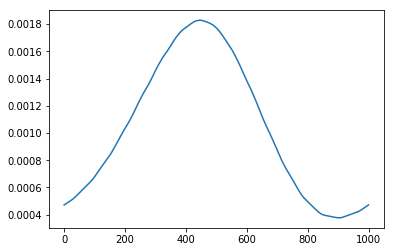

In [47]:
plt.plot(blc)

In [60]:
def RunTests(star, planet, points, base):
    data = np.zeros(shape=(points.shape[0],4))
    _star = star
    _planet = planet
    _system = ebm.System(_star,_planet)
    for i in range(0, points.shape[0]):
        
        _star = star
        _planet = planet        
        _planet.map = ebm.Map.Map(nlat=points[i,1])
        _system = ebm.System(_star, _planet)
        
        data[i,0] = points[i,0]
        data[i,1] = points[i,1]
        
        tInt = time.time()
        
        Teq = _system.get_teq()
        T0 = np.ones_like(_system.planet.map.values)*Teq
        t0 = 0.
        t1 = t0+_system.planet.Porb
        dt = _system.planet.Porb/points[i,0]
        testTimes, testMaps = system.run_model(T0, t0, t1, dt, verbose=False)
        if (_planet.orbit.e != 0):
            T0 = testMaps[-1]
            t0 = testTimes[-1]
            t1 = t0+_system.planet.Porb
            dt = system.planet.Porb/points[i,0]
            testTimes, testMaps = system.run_model(T0, t0, t1, dt, verbose=False, intermediates=True)
            testLightcurve = system.lightcurve(testTimes, testMaps, bolo=False, wav=4.5e-6)
            
            phaseTest = _system.get_phase(testTimes).flatten()
            order = np.argsort(phaseTest)
            testLightcurve = testLightcurve[order]
            phaseTest = phaseTest[order]
            testLightcurve = np.interp(base, phaseTest, testLightcurve)
        else:
            testLightcurve = system.lightcurve(bolo=False, wav=4.5e-6)

        tFin = time.time()
        
        data[i,3] = (1e6)*(np.amax(np.absolute(base - testLightcurve)))
        data[i,2] = (tFin - tInt)*(1e3)

    return testLightcurve, data


In [7]:
p = np.zeros(shape=((10),2))

In [54]:
p[:,0]=100
p[:,1]=6
p[9,0] = 1000
p[9,1] = 16

In [55]:
p

array([[ 100.,    6.],
       [ 100.,    6.],
       [ 100.,    6.],
       [ 100.,    6.],
       [ 100.,    6.],
       [ 100.,    6.],
       [ 100.,    6.],
       [ 100.,    6.],
       [ 100.,    6.],
       [1000.,   16.]])

In [56]:
lc, data = RunTests(star,planet,p,blc)

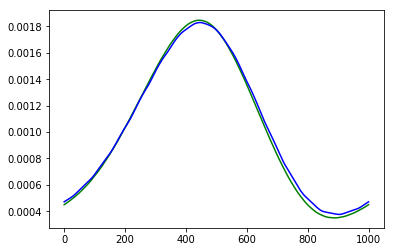

In [57]:
plt.plot(lc, c='g')
plt.plot(blc, c='b')

In [58]:
data

array([[  0.        ,   0.        ,  34.56783295,  42.6892182 ],
       [  0.        ,   0.        ,  29.05511856,  42.6892182 ],
       [  0.        ,   0.        ,  24.0020752 ,  42.6892182 ],
       [  0.        ,   0.        ,  23.55313301,  42.6892182 ],
       [  0.        ,   0.        ,  33.12206268,  42.6892182 ],
       [  0.        ,   0.        ,  35.02988815,  42.6892182 ],
       [  0.        ,   0.        ,  23.74386787,  42.6892182 ],
       [  0.        ,   0.        ,  24.62625504,  42.6892182 ],
       [  0.        ,   0.        ,  24.06191826,  42.6892182 ],
       [  0.        ,   0.        , 291.53609276,  52.57132783]])

Starting baseline generation...
Baseline generation complete; Time to Compute: 6.48s
First pass data points assigned
Starting first pass...
First pass finished : Time to compute: 3.93s
Processing first pass data...
Second pass data points assigned
Starting second pass...
Second pass finished : Time to compute: 1.2s
Processing second pass data...
Temporal: 150.0 Spacial: 4.0
Time for compute: 23.92ms : Error: 68.4ppm
Expected compute time @ 1,000,000 cycles: 6.64 Hrs


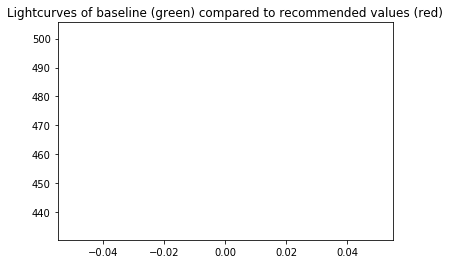

In [43]:
opt.Optimize(planet, star, 100, verbose=True)

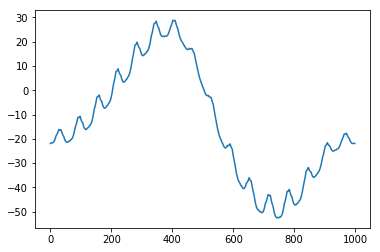

In [59]:
plt.plot((1e6)*(lc-blc))

In [63]:
def Optimize(star, planet, error, verbose=False):
    _planet = planet
    _star = star
    aError = error

    #==========High Res Baseline Creation==========    
    if (verbose == True): 
        print("Starting baseline generation...")
    
    tInt = time.time()
    blt, blm, blc = CreateBaseline(_star, _planet)
    tFin = time.time()
    
    if (verbose == True): 
        print("Baseline generation complete; Time to Compute: " + str(round(tFin-tInt,2)) + "s")

    #===========Initial data creationg================
    space_points = 5
    temp_points = 5
    data = np.zeros(shape=((space_points*temp_points),4))
    for i in range (0, temp_points):
        for j in range (0, space_points):
            data[(i*space_points)+j,0]= ((i+1)*250)+0
            data[(i*space_points)+j,1] = ((j+1)*4)+0
    if (verbose == True): 
        print("First pass data points assigned")

    #==================First pass testing Area======================
    if (verbose == True): 
        print("Starting first pass...")
        
    tInt = time.time()
    lc, data = RunTests(_star, _planet, data, blc)
    tFin = time.time()
    
    if (verbose == True): 
        print("First pass finished : Time to compute: " + str(round(tFin-tInt,2)) + "s")

    #=================First pass best point===================
    #print(data) #For debugging purposes 
    if (verbose == True):
        print("Processing first pass data...")
    iBest = None
    for i in range(0,space_points*temp_points):
        if (data[i,3]<=(aError*1.05)):
            if (iBest == None):
                iBest = i
            if(data[i,2] < data[iBest,2]):
                iBest = i
                
    #===========Second pass data creation================
    space_points = 5
    temp_points = 5
    dataDouble = np.zeros(shape=((space_points*temp_points),2))
    for i in range (0, temp_points):
        for j in range (0, space_points):
            dataDouble[(i*space_points)+j,0] = ((i)*50)+(data[iBest,0]-100)
            if (dataDouble[(i*space_points)+j,0]<100):
                dataDouble[(i*space_points)+j,0] = 100
            dataDouble[(i*space_points)+j,1] = ((j)*2)+(data[iBest,1]-4)
            if (dataDouble[(i*space_points)+j,1]<2):
                dataDouble[(i*space_points)+j,1] = 2
    if (verbose == True): 
        print("Second pass data points assigned")
    
    #==================Second pass testing Area======================
    if (verbose == True): 
        print("Starting second pass...")
        
    tInt = time.time()
    lc, dataDouble = RunTests(_star, _planet, dataDouble, blc)
    tFin = time.time()
    if (verbose == True): 
        print("Second pass finished : Time to compute: " + str(round(tFin-tInt,2)) + "s")
    
    #=================Finding best second pass point===================
    #print(data) #For debugging purposes 
    if (verbose == True):
        print("Processing second pass data...")
    iBest = None
    for i in range(0,space_points*temp_points):
        if (dataDouble[i,3]<=aError):
            if (iBest == None):
                iBest = i
            if(dataDouble[i,2] < dataDouble[iBest,2]):
                iBest = i

    if (iBest == None):
        print("No points match requested error")
    else:
        print("Temporal: " + str(dataDouble[iBest,0]) + " Spacial: " + str(dataDouble[iBest,1]))
        print("Time for compute: " + str(round(dataDouble[iBest, 2],2)) +"ms : Error: " + str(round(dataDouble[iBest, 3],2)) + "ppm")
        print("Expected compute time @ 1,000,000 cycles: " + str((round((dataDouble[iBest, 2]*1e3/60)/60,2))) + " Hrs")
       
    return dataDouble[iBest,0], dataDouble[iBest,1]
#     #print(data) #For debugging
#     #print(dataDouble) #For debugging
#     #=========Create Maps==================
#     if (verbose == True):
#         planet.map = ebm.Map.Map(nlat=dataDouble[iBest,1])
#         system = ebm.System(star, planet)

#         TotalTimeToCompute = 0.

#         Teq = system.get_teq()
#         T0 = np.ones_like(system.planet.map.values)*Teq
#         t0 = 0.
#         t1 = t0+system.planet.Porb*1
#         dt = system.planet.Porb/dataDouble[iBest,0]
#         times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)
#         TotalTimeToCompute += ttc

#         if (planet.orbit.e != 0):
#             T0 = maps[-1]
#             t0 = times[-1]
#             t1 = t0+system.planet.Porb
#             dt = system.planet.Porb/dataDouble[iBest,0]
#             times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
#             TotalTimeToCompute += ttc

#         testLightcurve = system.lightcurve(times, maps, bolo=False, wav=4.5e-6)

#         phaseTest = system.get_phase(times).flatten()
#         order = np.argsort(phaseTest)
#         testLightcurve = testLightcurve[order]
#         phaseTest = phaseTest[order]
#         testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
        

#         plt.plot((baselineLightcurve)*1e6, lw=2, c='g')
#         plt.plot((testLightcurve)*1e6, lw=1, c='r')
#         plt.title("Lightcurves of baseline (green) compared to recommended values (red)")
#         plt.show()



In [67]:
temp, space = Optimize(star, planet, 25, verbose=False)

Temporal: 150.0 Spacial: 12.0
Time for compute: 61.32ms : Error: 19.31ppm
Expected compute time @ 1,000,000 cycles: 17.03 Hrs


TypeError: cannot unpack non-iterable NoneType object